In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve


In [28]:
df=pd.read_csv('travel_insurance/train.csv')

In [29]:
df

,Customer Id,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,3JUN0VW6F043,34,Private Sector/Self Employed,Yes,1300000,6,0,Yes,No,No
1,VLHY2ABIR4QL,28,Private Sector/Self Employed,Yes,750000,7,0,Yes,No,No
2,6E3F7UNXYNFF,28,Private Sector/Self Employed,Yes,750000,6,0,Yes,No,No
3,JJ8R0ZRYWR31,32,Government Sector,Yes,800000,6,1,No,No,No
4,2WGFUEX6IEHM,34,Private Sector/Self Employed,Yes,700000,4,1,No,No,No
...,...,...,...,...,...,...,...,...,...,...
1585,W9JDK752JWHA,29,Private Sector/Self Employed,Yes,600000,3,0,No,No,No
1586,2JEE5P5T9MT0,34,Private Sector/Self Employed,Yes,850000,3,1,No,Yes,No
1587,797K83M5QWO2,34,Private Sector/Self Employed,No,1300000,4,0,No,No,No
1588,8V9QYC8TCCMF,33,Government Sector,Yes,400000,5,0,No,No,No


In [30]:
df.isna().sum()

Customer Id            0
Age                    0
Employment Type        0
GraduateOrNot          0
AnnualIncome           0
FamilyMembers          0
ChronicDiseases        0
FrequentFlyer          0
EverTravelledAbroad    0
TravelInsurance        0
dtype: int64

In [31]:
df.drop(columns=['Customer Id'],inplace=True)

In [32]:
cat_column=['Employment Type','GraduateOrNot','FrequentFlyer','EverTravelledAbroad','TravelInsurance']
for i in cat_column:
    df[i] = pd.Categorical(df[i])
    df[i] = df[i].cat.codes

In [33]:
a=df.corr()
a['TravelInsurance'].sort_values()

GraduateOrNot          0.021951
ChronicDiseases        0.030956
FamilyMembers          0.070212
Age                    0.071458
Employment Type        0.144589
FrequentFlyer          0.228248
AnnualIncome           0.399573
EverTravelledAbroad    0.449405
TravelInsurance        1.000000
Name: TravelInsurance, dtype: float64

In [34]:
"""
these columns don't have correlation with label but drop them out increase the accuracy of models...
"""
# df.drop(columns=['GraduateOrNot','ChronicDiseases','FamilyMembers','Age'],inplace=True)

"\nthese columns don't have correlation with label but drop them out increase the accuracy of models...\n"

In [35]:
x=df.drop(columns=['TravelInsurance'])
y=df['TravelInsurance']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=54,)

##### GridSearch

In [80]:
classifier = [DecisionTreeClassifier(),
             SVC(),
             RandomForestClassifier(),
             LogisticRegression(),
             KNeighborsClassifier(),
             SGDClassifier()
            ]

dt_param_grid = {"min_samples_split" : range(10,100,10),
                "max_depth": range(1,10)}

svc_param_grid = {"kernel" : ["rbf",'poly'],
                 "gamma": [0.001, 0.1, 1],
                 "C": [0.1, 1,10],
                 'degree':[2,3]}

rf_param_grid = {"max_features": [1,10],
                "min_samples_split":[2,10],
                "min_samples_leaf":[1,10],
                "bootstrap":[False],
                "n_estimators":[100],
                "criterion":["gini",'antropy']}

logreg_param_grid = {"C":np.logspace(-2, 2),
                    "penalty": ["l1","l2","none"]}

knn_param_grid = {"n_neighbors": np.linspace(2,20, dtype = int).tolist(),
                 "metric":["manhattan"],
                 "leaf_size": [1,5,10]}

sgdc_param_grid = {
    "loss" : ["hinge", "log"],
    "alpha" : [ 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "none"]}




classifier_param = [dt_param_grid,
                   svc_param_grid,
                   rf_param_grid,
                   logreg_param_grid,
                   knn_param_grid,
                   sgdc_param_grid
                 ]

cv_result = []
best_estimators = []
mean_squared_errors = []
recall_scores = []
precision_scores = []
f1_scores = []
roc_auc=[]

for i in range(len(classifier)):
    print("---------------------------------------------------------------------------")
    clf = GridSearchCV(classifier[i],
                       param_grid=classifier_param[i],
                       cv = StratifiedKFold(n_splits = 3),
                       scoring = "accuracy",
                       n_jobs = -1,verbose = 2)
    
    clf.fit(X_train,y_train)
    
    cv_result.append(clf.best_score_)
    
    mean_squared_errors.append(mean_squared_error(y_test,clf.predict(X_test)))

    roc_auc.append(roc_auc_score(y_test,clf.predict(X_test)))
    recall_scores.append(recall_score(y_test, clf.predict(X_test), average='weighted'))
    
    precision_scores.append(precision_score(y_test, clf.predict(X_test), average='weighted'))
    
    f1_scores.append(f1_score(y_test, clf.predict(X_test), average='weighted'))
    
    best_estimators.append(clf.best_estimator_)
    
    print("Model: {}".format(classifier[i]))
    print("Accuracy: %{}".format(round(cv_result[i]*100,2)))
    print("MSE: {}".format(mean_squared_errors[i]))
    print('roc score:{}'.format(roc_auc[i]))
    print("Recall: {}".format(recall_scores[i]))
    print("Precision: {}".format(precision_scores[i]))
    print("F1-Score: {}".format(f1_scores[i]))
    print("Best Estimator: {}".format(clf.best_estimator_))
    
print("---------------------------------------------------------------------------")

sns.set_style("darkgrid")
cv_results = pd.DataFrame({"Accuracy":cv_result,
                           "MSE":mean_squared_errors,
                           "Recall": recall_scores,
                           "Precision": precision_scores,
                           "F1-Score":f1_scores,
                           'roc':roc_auc,
                           "Models":["DecisionTreeClassifier", 
                                     "SVC",
                                     "RandomForestClassifier",
                                     "LogisticRegression",
                                     "KNeighborsClassifier",
                                     "SGDClassifier"
                                   ]})

cv_results.index = cv_results["Models"]

cv_results  = cv_results.drop(["Models"], axis = 1)

f,ax = plt.subplots(figsize=(14,10))

sns.heatmap(cv_results, annot=True,cmap = "Blues",fmt= '.3f',
            ax=ax,linewidths = 5, cbar = False,
            annot_kws={"size": 18})

plt.xticks(size = 18)
plt.yticks(size = 18, rotation = 0)
plt.ylabel("Models")
plt.title("Grid Search Results", size = 16)
plt.show()

---------------------------------------------------------------------------
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Model: DecisionTreeClassifier()
Accuracy: %84.1
MSE: 0.16771488469601678
roc score:0.7623817034700316
Recall: 0.8322851153039832
Precision: 0.8464594441418092
F1-Score: 0.8190096892589188
Best Estimator: DecisionTreeClassifier(max_depth=3, min_samples_split=10)
---------------------------------------------------------------------------
Fitting 3 folds for each of 36 candidates, totalling 108 fits


KeyboardInterrupt: 

/home/sara/Documents/python/mlvenv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


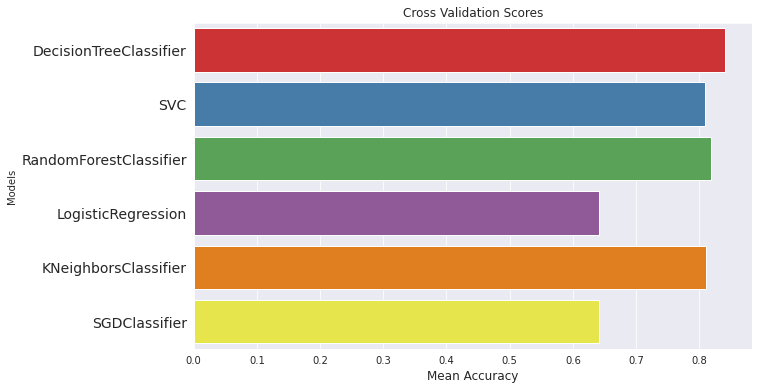

In [37]:
sns.set_style("darkgrid")
cv_results = pd.DataFrame({"Cross Validation Means":cv_result,
                           "Models":["DecisionTreeClassifier", "SVC",
                                     "RandomForestClassifier",
                                     "LogisticRegression",
                                     "KNeighborsClassifier",
                                     "SGDClassifier"
                                    ]})

plt.figure(figsize = (10,6))
sns.barplot("Cross Validation Means", "Models",
            data = cv_results, palette = "Set1")
plt.xlabel("Mean Accuracy",
           size = 12)
plt.yticks(size = 14)
plt.title("Cross Validation Scores",
          size = 12)
plt.show()

#### scaling

In [41]:

scale_min_max=MinMaxScaler()
x_train_scale=scale_min_max.fit_transform(X_train,y_train)
x_test_scale=scale_min_max.transform(X_test)

In [47]:
scale_standard=StandardScaler()
x_train_scale=scale_standard.fit_transform(X_train,y_train)
x_test_scale=scale_standard.fit_transform(X_test)

[CV] END .......leaf_size=5, metric=manhattan, n_neighbors=8; total time=   0.0s
[CV] END .......leaf_size=5, metric=manhattan, n_neighbors=9; total time=   0.0s
[CV] END .......leaf_size=5, metric=manhattan, n_neighbors=9; total time=   0.0s
[CV] END ......leaf_size=5, metric=manhattan, n_neighbors=11; total time=   0.0s
[CV] END ......leaf_size=5, metric=manhattan, n_neighbors=11; total time=   0.0s
[CV] END ......leaf_size=5, metric=manhattan, n_neighbors=11; total time=   0.0s
[CV] END ......leaf_size=5, metric=manhattan, n_neighbors=11; total time=   0.0s
[CV] END ......leaf_size=5, metric=manhattan, n_neighbors=13; total time=   0.0s
[CV] END ......leaf_size=5, metric=manhattan, n_neighbors=13; total time=   0.0s
[CV] END ......leaf_size=5, metric=manhattan, n_neighbors=13; total time=   0.0s
[CV] END ......leaf_size=5, metric=manhattan, n_neighbors=13; total time=   0.0s
[CV] END ......leaf_size=5, metric=manhattan, n_neighbors=14; total time=   0.0s
[CV] END ......leaf_size=5, 

[CV] END ......leaf_size=5, metric=manhattan, n_neighbors=10; total time=   0.0s
[CV] END ......leaf_size=5, metric=manhattan, n_neighbors=12; total time=   0.0s
[CV] END ......leaf_size=5, metric=manhattan, n_neighbors=12; total time=   0.0s
[CV] END ......leaf_size=5, metric=manhattan, n_neighbors=12; total time=   0.0s
[CV] END ......leaf_size=5, metric=manhattan, n_neighbors=12; total time=   0.0s
[CV] END ......leaf_size=5, metric=manhattan, n_neighbors=14; total time=   0.0s
[CV] END ......leaf_size=5, metric=manhattan, n_neighbors=14; total time=   0.0s
[CV] END ......leaf_size=5, metric=manhattan, n_neighbors=14; total time=   0.0s
[CV] END ......leaf_size=5, metric=manhattan, n_neighbors=14; total time=   0.0s
[CV] END ......leaf_size=5, metric=manhattan, n_neighbors=16; total time=   0.0s
[CV] END ......leaf_size=5, metric=manhattan, n_neighbors=16; total time=   0.0s
[CV] END ......leaf_size=5, metric=manhattan, n_neighbors=16; total time=   0.0s
[CV] END ......leaf_size=5, 

In [45]:
best_estimators

[DecisionTreeClassifier(max_depth=3, min_samples_split=10),
 SVC(C=1, gamma=0.1),
 RandomForestClassifier(bootstrap=False, max_features=1, min_samples_leaf=10,
                        min_samples_split=10),
 LogisticRegression(C=0.01),
 KNeighborsClassifier(leaf_size=1, metric='manhattan', n_neighbors=4),
 SGDClassifier(alpha=0.001)]

### RandomForestClassifier

In [48]:
RFmodel=RandomForestClassifier(bootstrap=False, max_features=1, min_samples_leaf=10)
RFmodel.fit(x_train_scale,y_train)

y_pred_rf = RFmodel.predict(x_test_scale)

print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.79      0.96      0.87       317
           1       0.87      0.48      0.62       160

    accuracy                           0.80       477
   macro avg       0.83      0.72      0.74       477
weighted avg       0.81      0.80      0.78       477



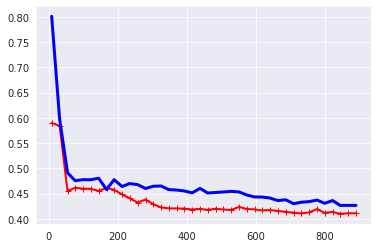

In [36]:
train_sizes, train_scores, valid_scores = learning_curve(
   RFmodel, X_train, y_train, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error"
)

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")

### DecisionTreeClassifier

In [73]:
DTmodel= DecisionTreeClassifier(max_depth=3, min_samples_split=4)


DTmodel.fit(X_train,y_train)

y_pred = DTmodel.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89       317
           1       0.92      0.56      0.70       160

    accuracy                           0.84       477
   macro avg       0.87      0.77      0.79       477
weighted avg       0.85      0.84      0.82       477



In [78]:
DTmodel_scale= DecisionTreeClassifier(max_depth=3, min_samples_split=8)


DTmodel_scale.fit(x_train_scale,y_train)

y_pred_scale= DTmodel_scale.predict(x_test_scale)

print(classification_report(y_test, y_pred_scale))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89       317
           1       0.92      0.56      0.70       160

    accuracy                           0.84       477
   macro avg       0.87      0.77      0.79       477
weighted avg       0.85      0.84      0.82       477



In [ ]:
"""
scaling is not affected
"""

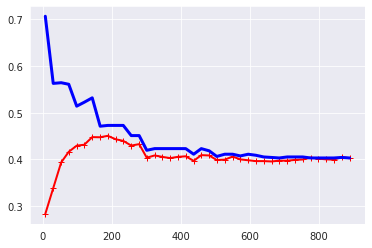

In [34]:


train_sizes, train_scores, valid_scores = learning_curve(
   DTmodel, X_train, y_train, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error"
)

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")

### SVC

In [ ]:
svc=SVC(C=1, gamma=0.1,probability=True)

svc.fit(X_train,y_train)

y_pred_svc= svc.predict(X_test)

print(classification_report(y_test, y_pred_svc))

### voting weak classifier

In [129]:

svc=SVC(C=1, gamma=0.1,probability=True)
lr=LogisticRegression(C=0.01)

In [130]:

votting_clf =VotingClassifier( estimators = [ ('lr',lr),('svc', svc)], voting = 'soft')

In [131]:


for clf in (svc,lr,votting_clf):
    clf.fit(X_train, y_train)
    y_pred_vot = clf.predict(X_test)
    print(clf.__class__.__name__ , accuracy_score(y_test, y_pred_vot))

DecisionTreeClassifier 0.8322851153039832
RandomForestClassifier 0.8092243186582809
SVC 0.80083857442348
KNeighborsClassifier 0.8050314465408805
LogisticRegression 0.6645702306079665
VotingClassifier 0.8155136268343816


### BaggingClassifier

In [148]:

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_depth=3, min_samples_split=10), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)


In [149]:
bag_clf.fit(X_train, y_train)
y_pred_bag= bag_clf.predict(X_test)
accuracy_score(y_test, y_pred_bag)

0.8155136268343816

### AdaBoostClassifier

In [154]:

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=3,min_samples_split=10), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5
    )

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         min_samples_split=10),
                   learning_rate=0.5, n_estimators=200)

In [155]:
y_pred_ada= ada_clf.predict(X_test)
accuracy_score(y_test, y_pred_ada)

0.7819706498951782

In [68]:
df_test=pd.read_csv('travel_insurance/test.csv')

In [38]:
df_test

,Customer Id,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad
0,Q5OK4L2Q5XNH,34,Government Sector,Yes,1300000,7,0,No,No
1,CBHVMVE7TRP5,28,Private Sector/Self Employed,Yes,1450000,4,0,Yes,Yes
2,9UGHQ91U4F0M,28,Private Sector/Self Employed,Yes,900000,9,1,No,Yes
3,3UWXWMZK4ZGL,33,Private Sector/Self Employed,Yes,1500000,5,0,Yes,Yes
4,5CGEMLMBOPES,26,Government Sector,Yes,500000,5,0,No,No
...,...,...,...,...,...,...,...,...,...
392,3T4IU1ZJNDIA,32,Government Sector,Yes,800000,6,1,No,No
393,N3ON6CQWDU4Z,30,Private Sector/Self Employed,No,800000,4,0,No,No
394,LWW08WASNJ2T,28,Private Sector/Self Employed,Yes,1200000,5,1,No,No
395,L2RAKTUJP4HS,28,Private Sector/Self Employed,Yes,550000,4,0,No,No


In [69]:
cat_column=['Employment Type','GraduateOrNot','FrequentFlyer','EverTravelledAbroad']
for i in cat_column:
    df_test[i] = pd.Categorical(df_test[i])
    df_test[i] = df_test[i].cat.codes

In [40]:
df_test

,Customer Id,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad
0,Q5OK4L2Q5XNH,34,0,1,1300000,7,0,0,0
1,CBHVMVE7TRP5,28,1,1,1450000,4,0,1,1
2,9UGHQ91U4F0M,28,1,1,900000,9,1,0,1
3,3UWXWMZK4ZGL,33,1,1,1500000,5,0,1,1
4,5CGEMLMBOPES,26,0,1,500000,5,0,0,0
...,...,...,...,...,...,...,...,...,...
392,3T4IU1ZJNDIA,32,0,1,800000,6,1,0,0
393,N3ON6CQWDU4Z,30,1,0,800000,4,0,0,0
394,LWW08WASNJ2T,28,1,1,1200000,5,1,0,0
395,L2RAKTUJP4HS,28,1,1,550000,4,0,0,0


In [70]:
df_test1=df_test.drop(columns=['Customer Id'])

In [71]:
df_test1

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad
0,34,0,1,1300000,7,0,0,0
1,28,1,1,1450000,4,0,1,1
2,28,1,1,900000,9,1,0,1
3,33,1,1,1500000,5,0,1,1
4,26,0,1,500000,5,0,0,0
...,...,...,...,...,...,...,...,...
392,32,0,1,800000,6,1,0,0
393,30,1,0,800000,4,0,0,0
394,28,1,1,1200000,5,1,0,0
395,28,1,1,550000,4,0,0,0


In [75]:
y_pred_dt= DTmodel.predict(df_test1)

In [76]:
y_pred_dt

array([1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

In [132]:
y_pred_v= votting_clf.predict(df_test1)

In [133]:
y_pred_v


array([1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

In [134]:
pred_df=pd.DataFrame(y_pred_v)

pred_df['prediction']=pred_df[0]

In [135]:
result = pd.concat([df_test, pred_df], axis=1)

In [136]:
result

,Customer Id,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,0,prediction
0,Q5OK4L2Q5XNH,34,0,1,1300000,7,0,0,0,1,1
1,CBHVMVE7TRP5,28,1,1,1450000,4,0,1,1,1,1
2,9UGHQ91U4F0M,28,1,1,900000,9,1,0,1,0,0
3,3UWXWMZK4ZGL,33,1,1,1500000,5,0,1,1,1,1
4,5CGEMLMBOPES,26,0,1,500000,5,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
392,3T4IU1ZJNDIA,32,0,1,800000,6,1,0,0,0,0
393,N3ON6CQWDU4Z,30,1,0,800000,4,0,0,0,0,0
394,LWW08WASNJ2T,28,1,1,1200000,5,1,0,0,0,0
395,L2RAKTUJP4HS,28,1,1,550000,4,0,0,0,0,0


In [137]:
drop_column=['Employment Type','Age','GraduateOrNot','ChronicDiseases','AnnualIncome','FamilyMembers','FrequentFlyer','EverTravelledAbroad',0]
result.drop(columns=drop_column,inplace=True)

In [138]:


result


,Customer Id,prediction
0,Q5OK4L2Q5XNH,1
1,CBHVMVE7TRP5,1
2,9UGHQ91U4F0M,0
3,3UWXWMZK4ZGL,1
4,5CGEMLMBOPES,0
...,...,...
392,3T4IU1ZJNDIA,0
393,N3ON6CQWDU4Z,0
394,LWW08WASNJ2T,0
395,L2RAKTUJP4HS,0


In [139]:
result.to_csv('output.csv',index=False)

In [140]:
pd.read_csv('output.csv')

,Customer Id,prediction
0,Q5OK4L2Q5XNH,1
1,CBHVMVE7TRP5,1
2,9UGHQ91U4F0M,0
3,3UWXWMZK4ZGL,1
4,5CGEMLMBOPES,0
...,...,...
392,3T4IU1ZJNDIA,0
393,N3ON6CQWDU4Z,0
394,LWW08WASNJ2T,0
395,L2RAKTUJP4HS,0
